# Day 7: Coding Positional Embeddings 
- We discussed what positonal embeddings are and why they are essential in Transformer models. 
- Today, let's jump into the code and see exactly how they are implemented. 
- The reference implementation comes from an open-source GPT-style model, I've been experimenting with Tiny Children Stories 30M. 
- It is designed to generate short children's stories and offers a clean, minimal setup perfect for understanding the internals. 

## Quick Recap: Why Transformers Need Positional Embeddings 
- Transformer models process all tokens in parallel (unlike RNNs), so they don't naturally understand word order. For example: 
    - "The cat sat on the mat" 
    - "The mat sat on the cat" 
- To a transformer without positional embeddings, those look identical, same tokens, shuffled order, same representations. That is a problem. 

## What Are Positional Embeddings? 
- They are additional vectors that encode the position of each token in the sequence. 
- These are added to token embeddings so that the model knows what the token is and where it is located. 

### 1. Model Config 

In [ ]:
u/dataclass 
class GPTConfig: 
    vocab_size: int = 50257 
    block_size: int = 1024
    n_layer: int = 6 
    n_head: int = 8 
    n_embd: int = 512 
    dropout: float = 0.1 
    bias: bool = True

- block_size defines the maximum sequence length and thus the number of positional embeddings needed. 

### Defining the Embedding Layers 

In [ ]:
self.transformer = nn.ModuleDict(dict(
    wte=nn.Embedding(config.vocab_size, config.n_embd), # token embeddings 
    wpe=nn.Embedding(config.block_size, config.n_embd), # positional embeddings 
    # ...
))

- Both embeddings are of shape (sequence_length, embedding_dim), so they can be added together. 

### Forward Pass 

In [ ]:
pos = torch.arrange(0, t, dtype=torch.long, device=device)
tok_emb = self.transformer.wte(idx)
pos_emb = self.transformer.wpe(pos)
x = self.trasformer.drop(tok_emb + pos_emb)

- This does: 
    - Generate position indices [0, 1, 2,..., t-1]
    - Look up token and position embeddings 
    - Add them 
    - Apply dropout 

#### Example 
- Input: "The cat sat" 
- Token IDs: [464, 2368, 3290]
- 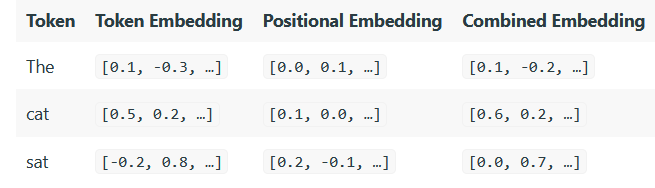
- Now the model knowns both the identity and the order of the tokens. 

#### Now the question is why This Matters
- By adding token + position, the model learns: 
    - Semantics (what the word is)
    - Context (where the word is)
- This is crucial in generation tasks like storytelling, where position changes meaning. 

#### Limitations 
- Fixed Length: Can't handle sequences longer than block_size. 
- No relative awarennes: Doesn't know how far two tokens are apart. 
- Sparse Training: If we never train on long sequences, performance drops. 

### Alternatives 
#### Sinusoidal Positional Embeddings 

In [5]:
def get_sinusoidal_embeddings(seq_len, embed_dim): 
    pos = torch.arange(seq_len).unsqueeze(1)
    div_term = torch.exp(torch.arrange(0, embed_dim, 2)) * -(math.log(10000.0) / embed_dim)
    pe = torch.zeros(seq_len, embed_dim)
    pe[:, 0::2] = torch.sin(pos * div_term)
    pe[:, 1::2] = torch.cos(pos * div_term)
    return pe 
# Infinite length
# No learned parameters 

#### Relative Positional Embeddings 
- Rather than saying "this is position 5," we tell the model "this token is 3 positions to the left of that one"
- Great for 
    - Reasoning 
    - Long document understanding 
    - Questions answering 

### Tips 
- Don't overextend block_size, it increases memory consumption fast. 
- Ensure our training data has diverse sequence lengths. 
- For long inputs, check out RoPE or relative embeddings.

# Final Thoughts 
- Positional embeddings are the quiet workhorses of transformer models.
- Just by combining two vectors (token + position), we enable the model to process ordered text meaningfully. 
- Without this, a model would not know if "The End" belongs at the start or the finish of our story. 